In [1]:
import pandas as pd
from datetime import datetime
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
data = pd.read_csv(r'..\preprocessing\tidy_data.csv', encoding = 'utf-8-sig')

In [3]:
# Số dòng và cột của dữ liệu
data.shape

(11372, 27)

In [4]:
# Các thuộc tính của dữ liệu
data.columns

Index(['name', 'brand', 'condition', 'price_old', 'price_new', 'warranty',
       'CPU', 'RAM', 'capacity', 'time', 'battery', 'screen_size',
       'operating_system', 'display_technology', 'weight', 'bluetooth',
       'refresh_rate', 'GPU', 'color', 'image', 'resolution_width',
       'resolution_height', 'has_nano_sim', 'has_esim', 'height', 'width',
       'depth'],
      dtype='object')

In [5]:
data.describe()

,price_old,price_new,RAM,capacity,battery,screen_size,weight,refresh_rate,resolution_width,resolution_height,has_nano_sim,has_esim,height,width,depth
count,1.137200e+04,1.137200e+04,11372.000000,11372.00000,11372.000000,11372.000000,11372.000000,11372.000000,11372.000000,11372.000000,11372.0,11372.000000,11372.000000,11372.000000,11372.000000
mean,8.355523e+06,1.334013e+07,7.421452,214.50809,4447.771632,6.128236,186.271808,95.453394,1061.372494,2051.085385,1.0,0.390960,156.283723,74.292399,11.336518
std,7.042468e+06,1.116572e+07,3.704754,155.06699,1275.740093,1.452865,27.832768,31.303219,514.678978,799.069121,0.0,0.487987,14.644492,12.286937,12.939470
min,1.500000e+05,4.100000e+05,0.046875,0.12500,1000.000000,1.770000,75.000000,30.000000,120.000000,160.000000,1.0,0.000000,71.500000,7.000000,5.000000
25%,2.750000e+06,4.290000e+06,6.000000,128.00000,4000.000000,6.360000,181.000000,90.000000,720.000000,1604.000000,1.0,0.000000,152.800000,71.600000,7.700000
50%,6.410000e+06,9.990000e+06,8.000000,256.00000,5000.000000,6.670000,191.000000,90.000000,1080.000000,2392.000000,1.0,0.000000,162.200000,75.900000,7.990000
75%,1.237000e+07,2.099000e+07,12.000000,256.00000,5030.000000,6.700000,198.000000,120.000000,1200.000000,2532.000000,1.0,1.000000,165.100000,77.100000,8.300000
max,3.707000e+07,4.799000e+07,16.000000,1024.00000,6600.000000,7.600000,240.000000,144.000000,3200.000000,3200.000000,1.0,1.000000,191.900000,132.600000,88.900000


# Tính khoảng thời gian điện thoại đã ra mắt

In [6]:
data['time'] = pd.to_datetime(data['time'])

In [7]:
# Tính toán khoảng thời gian hiện tại - 'time'
data['time_difference'] = datetime.now() - data['time']
data['time_difference'] = data['time_difference'].dt.days

In [8]:
data.drop(columns=['time'], inplace=True)

# Tính thời gian hết bảo hành

In [9]:
processed_results = []
current_date = datetime.now() # Lấy ngày và giờ hiện tại

for index, item in data['warranty'].items():
    item = str(item).strip() # Đảm bảo item là chuỗi và loại bỏ khoảng trắng

    # Kiểm tra nếu có chứa "tháng"
    if "tháng" in item:
        num_months_str = item.replace("tháng", "").strip()
        num_months = int(num_months_str)

        # Xử lý cộng tháng
        year = current_date.year
        month = current_date.month + num_months
        day = current_date.day

        while month > 12:
            month -= 12
            year += 1
                
        # Xử lý trường hợp ngày không hợp lệ sau khi cộng tháng
        try:
            new_date = datetime(year, month, day)
        except ValueError:
            # Nếu ngày không hợp lệ, lấy ngày cuối cùng của tháng đó
            last_day_of_month = calendar.monthrange(year, month)[1]
            new_date = datetime(year, month, last_day_of_month)

        # Cập nhật giá trị
        data.loc[index, 'warranty'] = new_date.strftime("%d/%m/%Y")
    else:
            datetime.strptime(item, "%d/%m/%Y")
            data.loc[index, 'warranty'] = item 

# Chuyển dữ liệu sang kiểu datetime
data['warranty'] = pd.to_datetime(data['warranty'], format='%d/%m/%Y', errors='coerce')

In [10]:
# Tạo một Series mới cho current_date
current_date_series = pd.Series([current_date] * len(data))

# Tính hiệu số ngày
time_remaining = data['warranty'] - current_date_series

# Lưu vào một cột mới
data['day_remaining_warranty'] = time_remaining.dt.days + 1

In [11]:
data.drop(columns=['warranty'], inplace=True)

# Encoding

## Xử lí operating system

Gom nhóm thành 4 nhóm hệ điều hành: iOS, Android, Feature OS và Other. Sau đó dùng LabelEncoder để encode 

In [12]:
# Hàm nhóm hệ điều hành vào các loại chính
def map_os_family(os):
    if pd.isnull(os):
        return 'Unknown'
    os = os.lower()
    if 'ios' in os:
        return 'iOS'
    elif 'android' in os:
        return 'Android'
    elif 'coloros' in os:
        return 'Android'
    elif 'miui' in os:
        return 'Android'
    elif 'hyperos' in os:
        return 'Android'
    elif 'funtouch' in os:
        return 'Android'
    elif 'oxygenos' in os:
        return 'Android'
    elif 'realme ui' in os:
        return 'Android'
    elif 'xos' in os:
        return 'Android'
    elif 'mocor' in os:
        return 'Android'
    elif 'series 30' in os or 's30' in os:
        return 'Feature OS'
    else:
        return 'Other'

# Tạo cột os
data['os'] = data['operating_system'].apply(map_os_family)

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['os'] = encoder.fit_transform(data['os'])
data = data.drop(columns = ['operating_system'])



## Xử lí CPU

Gom nhóm CPU thành các nhóm: Apple, Snapdragon, MediaTek, Exynos, Unisoc và dùng LabelEncoder để encode

In [13]:
data['chip'] = data['CPU'].str.extract(r'(Apple|Snapdragon|MediaTek|Exynos|Unisoc)', expand=False)

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['chip'] = encoder.fit_transform(data['chip'])
data = data.drop(columns = ['CPU'])


## Xử lí display technology

Dùng TfidfVetorizer để trích xuất các đặc trưng của thuộc tính

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
data['display_technology'] = data['display_technology'].fillna("Unknown")
display_tfidf = tfidf.fit_transform(data['display_technology'])
tfidf_df = pd.DataFrame(display_tfidf.toarray(), columns=tfidf.get_feature_names_out())
data = pd.concat([data, tfidf_df], axis=1)
data = data.drop(columns=['display_technology'])

## Xử lí condition

Gắn nhãn thủ công cho tình trạng của máy

In [15]:
# Định nghĩa các tình trạng và nhãn số tương ứng của chúng
condition_mapping = {
    'Cũ trầy xước cấn': 0,
    'Cũ trầy xước': 1,
    'Cũ': 2,
    'Cũ đẹp': 3,
}

# Ánh xạ mô tả thành các nhãn
data['condition'] = data['condition'].map(condition_mapping)

## Xử lí brand

Gắn nhãn thủ công cho nhãn dựa trên mức độ phổ biến và phân khúc thị trường của thương hiệu

In [16]:
print(data['brand'].unique())

['apple' 'samsung' 'oppo' 'realme' 'xiaomi' 'vivo' 'tecno' 'masstel'
 'honor' 'mobell' 'nokia' 'tcl' 'viettel']


In [17]:
# Định nghĩa thương hiệu và nhãn số tương ứng của chúng
brand_mapping = {
    'apple': 3,
    'samsung': 3,

    'honor': 2,
    'oppo': 2,
    'xiaomi': 2,
    'vivo': 2,
    
    'realme': 1,
    'tecno': 1,
    'nokia': 1,
    'tcl': 1,

    'mobell': 0,
    'viettel': 0,
    'masstel': 0
}

# Ánh xạ nhãn cho cột 'brand'
data['brand'] = data['brand'].map(brand_mapping)

## Xử lí name và color

Dùng LabelEncoder để encode cho name và color

In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['name'] = encoder.fit_transform(data['name'])
data['color'] = encoder.fit_transform(data['color'])



## Xử lí GPU

Dựa vào hiệu năng để gắn nhãn cho các dòng GPU

In [21]:
high_cond = data['GPU'].str.lower().str.contains(
    'adreno-7|adreno-8|mali-g7|mali-g76|mali-g77|mali-g78|apple-gpu 6|apple-gpu 5|immortalis|xclipse|powervr-series7xt', na=False)

low_cond = data['GPU'].str.lower().str.contains(
    'adreno-6|adreno-5|adreno-4|mali-g6|mali-g57|mali-g68|mali-g52|powervr-ge8320|xclipse-920|apple-gpu 4|adreno-619|adreno-644|adreno-670', na=False)

no_gpu_cond = data['GPU'].isna() | (data['GPU'].str.lower() == 'unknown')

conditions = [no_gpu_cond, high_cond, low_cond]
choices = ['0', '2', '1']

data['GPU'] = np.select(conditions, choices, default='1')
data['GPU'] = pd.to_numeric(data['GPU'])


## Xử lí bluetooth

Dựa vào phiên bản và các tính năng để gắn trọng số

In [24]:
# Bảng điểm version
version_score_map = {
    '2.1': 1.0,
    '4.2': 2.0,
    '5.0': 3.0,
    '5.1': 3.2,
    '5.2': 3.4,
    '5.3': 3.6,
    '5.4': 3.8,
    '6.0': 4.0
}

# Trọng số profile (loại bỏ EDR)
profile_points = {
    'apt-X Adaptive': 0.2,
    'apt-X HD': 0.15,
    'LHDC': 0.15,
    'apt-X': 0.1,
    'A2DP': 0.1,
    'LE': 0.1,
    'BLE': 0.05
}

# Hàm mã hóa
def encode_bluetooth_weighted(bluetooth_str):
    if pd.isna(bluetooth_str):
        return np.nan

    # Tìm version
    version_match = re.findall(r'v(\d\.\d)', bluetooth_str)
    version = version_score_map.get(version_match[0], 0) if version_match else 0

    # Tính điểm profile
    profile_score = sum(pt for profile, pt in profile_points.items() if profile in bluetooth_str)

    return round(version + profile_score, 2)

# Áp dụng vào cột
data['bluetooth'] = data['bluetooth'].apply(encode_bluetooth_weighted)

# Chọn thuộc tính

In [26]:
data = data.drop(columns = ['image'])

In [27]:
# Lấy ra tất cả các cột có kiểu dữ liệu là số
numerical_cols = data.select_dtypes(include=np.number).columns.tolist()

# Độ tương quan Spearman của các thuộc tính số
correlation_matrix = data[numerical_cols].corr(method='spearman')
target_column = 'price_old'

# Sắp xếp và hiển thị kết quả
correlation_with_target = correlation_matrix[target_column]
correlation_spearman_filtered = correlation_with_target.drop(target_column, errors='ignore').dropna()
sorted_correlation = correlation_spearman_filtered.sort_values(ascending=False)
print(f"Độ tương quan Spearman của '{target_column}' với các thuộc tính khác (sắp xếp giảm dần):")
print(sorted_correlation)

Độ tương quan Spearman của 'price_old' với các thuộc tính khác (sắp xếp giảm dần):
price_new                 0.984637
resolution_width          0.881789
has_esim                  0.802087
GPU                       0.801387
brand                     0.718125
capacity                  0.665957
RAM                       0.654045
resolution_height         0.647558
refresh_rate              0.565811
bluetooth                 0.484787
dynamic                   0.481246
2x                        0.479938
oled                      0.449838
weight                    0.432068
os                        0.381271
amoled                    0.370036
screen_size               0.223064
retina                    0.222608
width                     0.221503
xdr                       0.217819
condition                 0.120525
super                     0.053110
liquid                    0.046068
plus                     -0.004183
ltpo                     -0.021570
ltps                     -0.025673
name   

In [28]:
# Lọc các thuộc tính có độ tương quan dưới 0.05
low_correlation_features = sorted_correlation[abs(sorted_correlation) < 0.05]

print("Các thuộc tính có độ tương quan Spearman dưới 0.05:")
print(low_correlation_features)


Các thuộc tính có độ tương quan Spearman dưới 0.05:
liquid    0.046068
plus     -0.004183
ltpo     -0.021570
ltps     -0.025673
Name: price_old, dtype: float64


In [29]:
from sklearn.feature_selection import f_classif

# Tách features (X) và target (y)
X = data.select_dtypes(include=['number']).drop(columns=['price_old'])
X = X.fillna(0)
y = data['price_old']

# Tính ANOVA F-test
f_values, p_values = f_classif(X, y)

# Gộp kết quả vào một DataFrame
anova_results = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_values,
    'p-Value': p_values
})

# Sắp xếp theo F-Score giảm dần
anova_results = anova_results.sort_values(by='F-Score', ascending=False)

print(anova_results)

                   Feature      F-Score  p-Value
7              screen_size  1382.481352      0.0
3                price_new   798.498176      0.0
19                   depth   280.194143      0.0
18                   width   221.859154      0.0
17                  height   192.189049      0.0
6                  battery   172.223118      0.0
14       resolution_height   149.765065      0.0
11                     GPU   143.084484      0.0
4                      RAM   132.572017      0.0
16                has_esim   126.327245      0.0
13        resolution_width   117.107730      0.0
24                      2x   113.363333      0.0
26                 dynamic   111.245963      0.0
8                   weight   103.909912      0.0
10            refresh_rate    93.801543      0.0
1                    brand    89.256235      0.0
32                    oled    72.682207      0.0
28                     lcd    71.009320      0.0
37                     tft    61.400679      0.0
22                  

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [15] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [30]:
# Lọc các thuộc tính có p-value trên 0.05
anova_filtered = anova_results[abs(anova_results['p-Value']) > 0.05]

print("Các thuộc tính có giá trị p lớn hơn 0.05:")
print(anova_filtered)


Các thuộc tính có giá trị p lớn hơn 0.05:
   Feature   F-Score  p-Value
30    ltpo  0.766756      1.0


Dựa vào kết quả đo độ tương quan và ANOVA, loại bỏ các cột liên quan đến display_technology

In [31]:
data = data.drop(columns= tfidf_df.columns)

Loại bỏ các dòng có missing values

In [34]:
data = data.dropna()

Chuyển đổi đơn vị của price old và price new từ đồng sang ngàn đồng

In [36]:
data['price_old'] = data['price_old']/1000
data['price_new'] = data['price_new']/1000

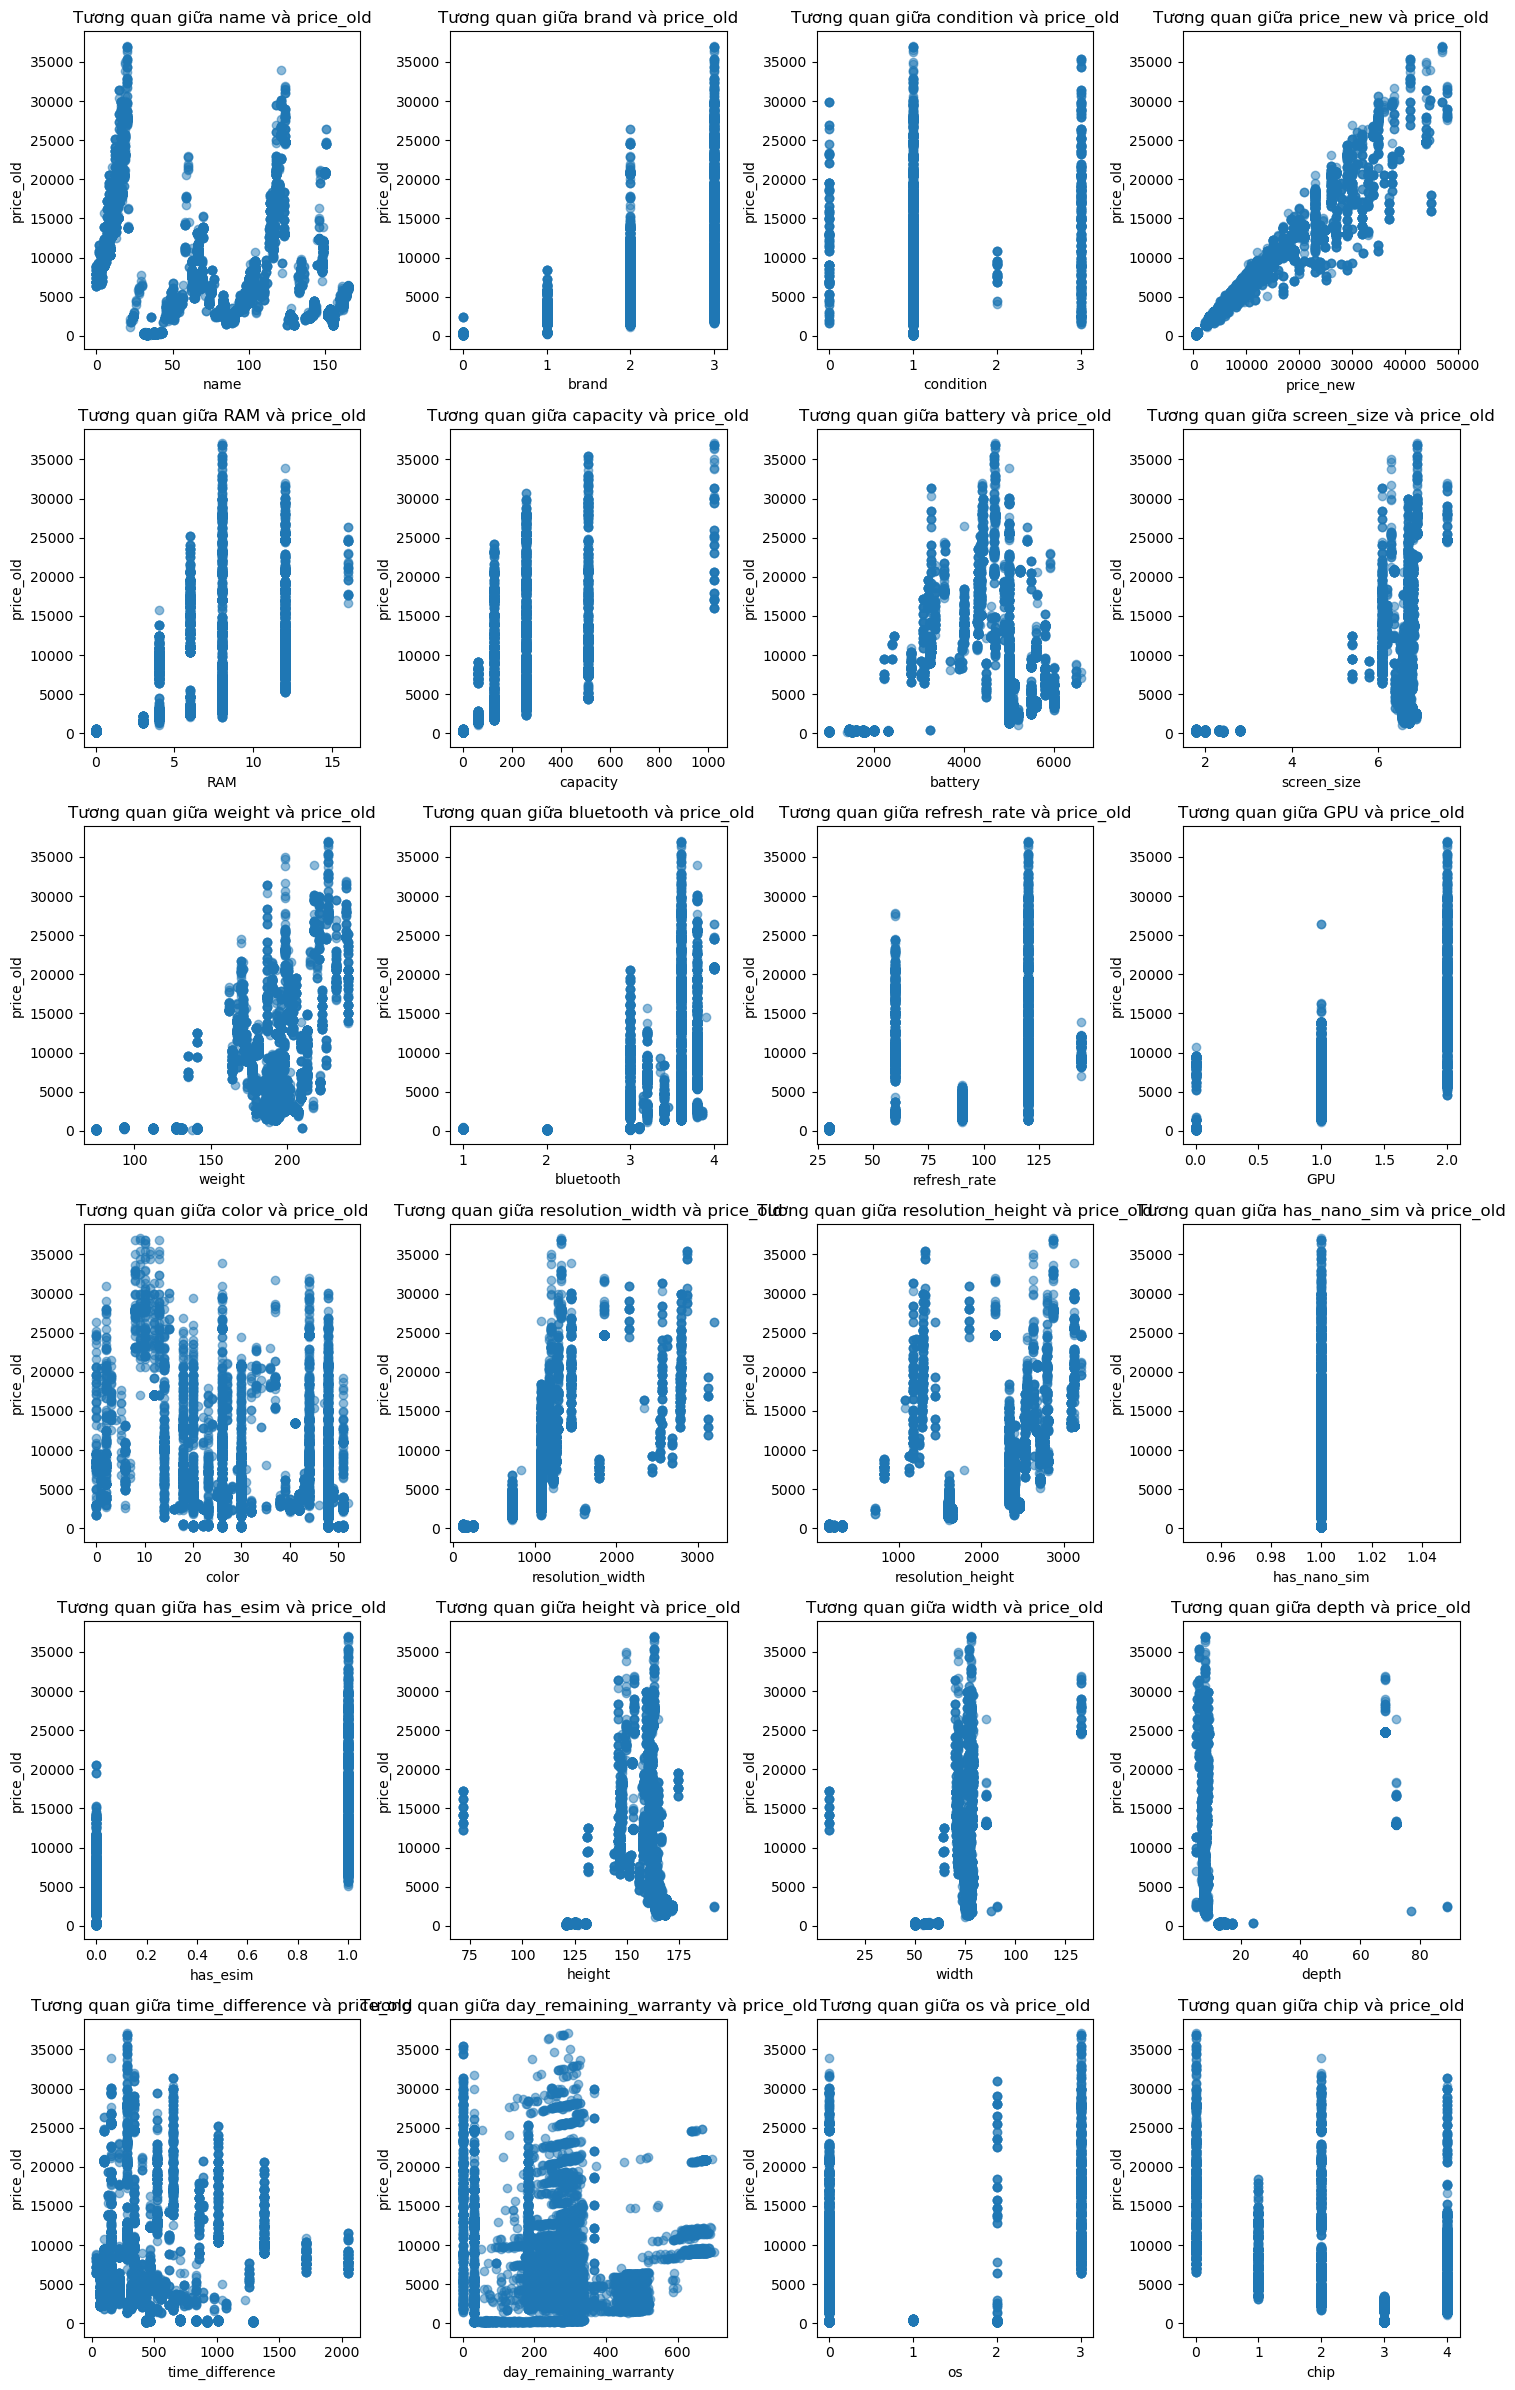

In [37]:
import matplotlib.pyplot as plt

# Lấy danh sách các cột số (ngoại trừ price_old)
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove("price_old")  # Loại bỏ target khỏi danh sách

# Vẽ tất cả các biểu đồ scatter
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, len(numerical_cols)))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].scatter(data[col], data["price_old"], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("price_old")
    axes[i].set_title(f"Tương quan giữa {col} và price_old")

plt.tight_layout()
plt.show()

In [38]:
data = data.drop(columns=['has_nano_sim', 'color', 'day_remaining_warranty'])

In [41]:
from sklearn.cluster import KMeans
import numpy as np

# Khởi tạo mô hình K-Means với k cụm
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)

# Huấn luyện mô hình
kmeans.fit(np.array(data))

# Nhận nhãn cụm và tâm cụm
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

print("Nhóm:", labels)
print("Tâm cụm:", centroids)

Nhóm: [1 1 1 ... 0 0 0]
Tâm cụm: [[9.27615088e+01 1.66477388e+00 1.03609815e+00 2.91305415e+03
  4.48461570e+03 5.54664368e+00 1.41012371e+02 4.60074833e+03
  5.94752890e+00 1.79813750e+02 3.15444129e+00 8.50233218e+01
  8.38166700e-01 7.80243358e+02 1.70210748e+03 2.63638207e-03
  1.59035628e+02 7.30277639e+01 9.10195701e+00 4.30936524e+02
  1.00385317e-01 3.22287568e+00]
 [8.00615901e+01 2.88577828e+00 1.21052632e+00 1.84334490e+04
  3.02878985e+04 9.92011945e+00 3.05164614e+02 4.39991079e+03
  6.66858529e+00 2.04778425e+02 3.62060470e+00 1.10123180e+02
  1.98394923e+00 1.55357633e+03 2.51311721e+03 9.87681971e-01
  1.56387663e+02 8.04995110e+01 1.96122882e+01 5.20933557e+02
  1.23404255e+00 1.25046659e+00]
 [7.50744424e+01 2.43851718e+00 1.06992164e+00 9.30125678e+03
  1.44112417e+04 9.13381555e+00 2.77757685e+02 4.69364316e+03
  6.50628692e+00 1.86597348e+02 3.53588005e+00 1.07542495e+02
  1.34960820e+00 1.19245961e+03 2.44026823e+03 5.34960820e-01
  1.57175066e+02 7.43896534e+01 7

In [42]:
data_clustered = pd.DataFrame(data)
data_clustered["Cluster"] = labels

# Hiển thị danh sách price_old theo từng cụm
print(data_clustered.groupby("Cluster")["price_old"].describe())


          count          mean          std     min      25%      50%      75%  \
Cluster                                                                         
0        4941.0   2918.743169  1546.296430   150.0   2300.0   2750.0   4060.0   
1        2679.0  18433.449048  5569.656501  8060.0  13040.0  17090.0  22950.0   
2        3308.0   9312.070738  2184.893271  4590.0   7440.0   9030.0  11030.0   

             max  
Cluster           
0         7010.0  
1        37070.0  
2        16340.0  


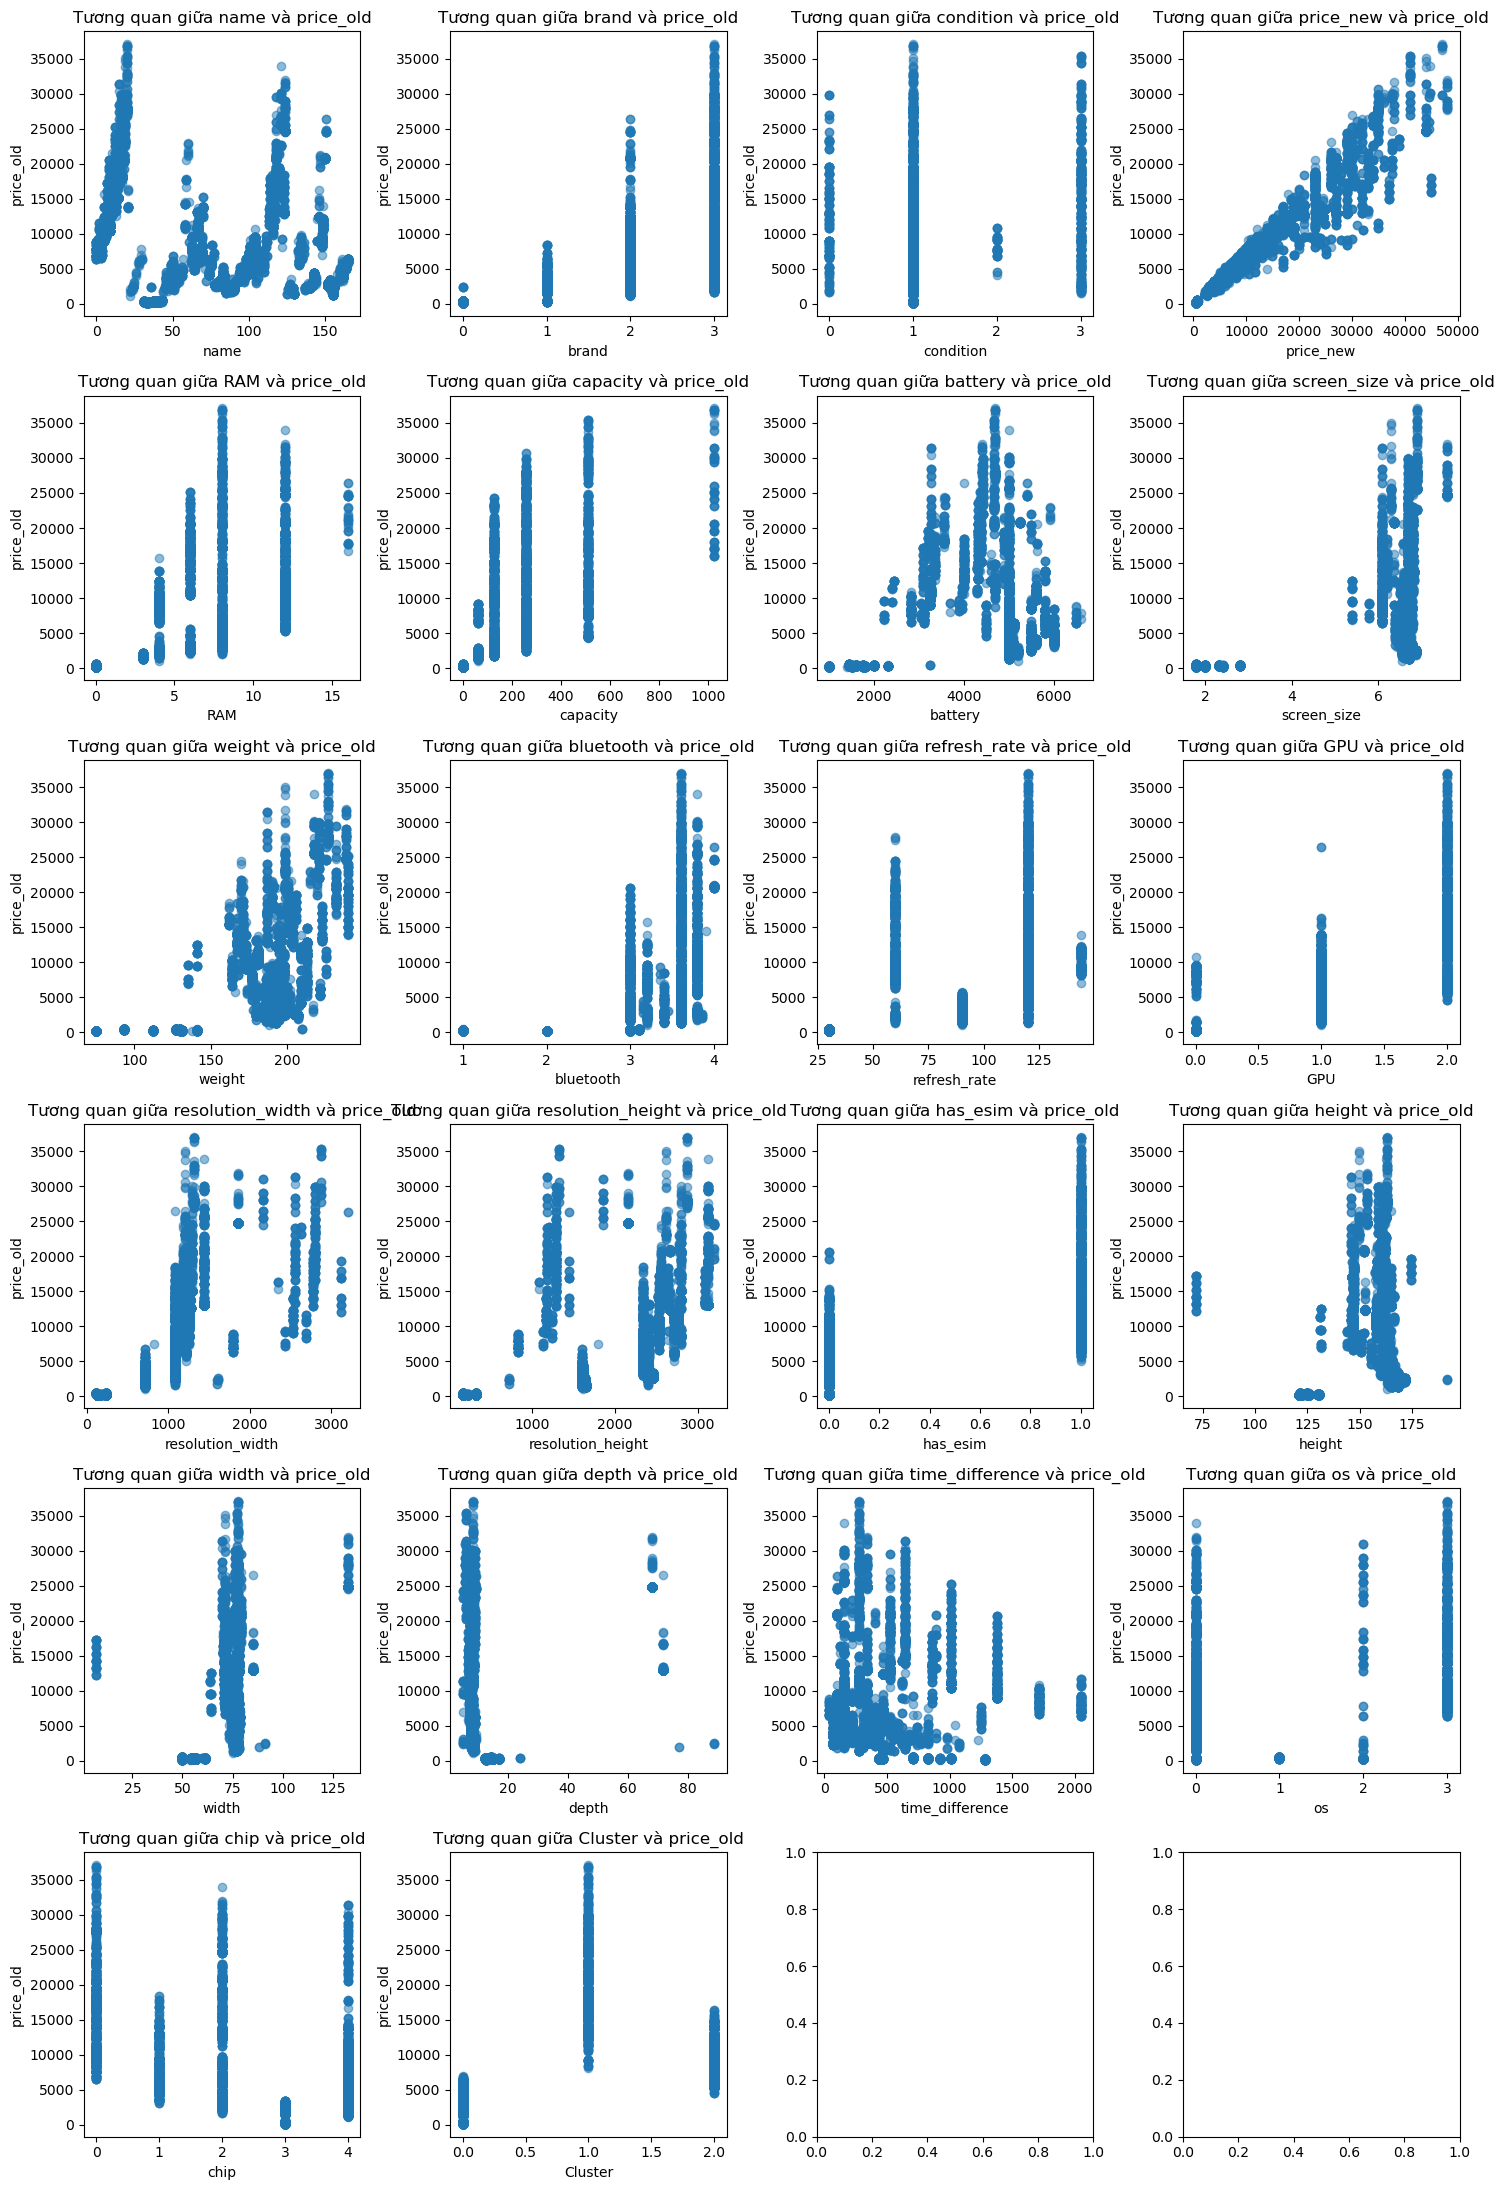

In [43]:
import matplotlib.pyplot as plt

# Lấy danh sách các cột số (ngoại trừ price_old)
numerical_cols = data_clustered.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove("price_old")  # Loại bỏ target khỏi danh sách

# Vẽ tất cả các biểu đồ scatter
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, len(numerical_cols)))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].scatter(data_clustered[col], data["price_old"], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("price_old")
    axes[i].set_title(f"Tương quan giữa {col} và price_old")

plt.tight_layout()
plt.show()

In [44]:
data_clustered.duplicated().sum()

8953

In [46]:
data_clustered = data_clustered.drop_duplicates()

In [48]:
data_clustered.shape

(1975, 23)

# Chia tập dữ liệu

In [50]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành tập huấn luyện và tập dev + test theo tỷ lệ 60:40
X_train, X_temp, y_train, y_temp = train_test_split(data_clustered.drop(columns=['price_old']), data_clustered["price_old"], test_size=0.4, random_state=42)

# Chia tiếp tập dev + test thành tập dev (20%) và tập test (20%)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


## Lưu các dữ liệu sau chia tập

In [51]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data.to_csv("train.csv")


In [52]:
dev_data = pd.concat([X_dev, y_dev], axis=1)
dev_data.to_csv("dev.csv")


In [53]:
test_data = pd.concat([X_test, y_test], axis=1)
test_data.to_csv("test.csv")


# Huấn luyện mô hình

In [54]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

## XGBRegressor

In [55]:
from xgboost import XGBRegressor

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

xgb = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

print("Các siêu tham số tối ưu: ", xgb.best_params_)
print("MSE tốt nhất:", -xgb.best_score_)
print("RMSE tốt nhất:", np.sqrt(-xgb.best_score_))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Các siêu tham số tối ưu:  {'colsample_bytree': 0.703783583411532, 'learning_rate': 0.10788079863717502, 'max_depth': 3, 'n_estimators': 471, 'subsample': 0.7526802067571363}
MSE tốt nhất: 799618.7801081585
RMSE tốt nhất: 894.2140572078692


In [56]:
xgb_regressor = xgb.best_estimator_

# Huấn luyện mô hình trên tập train
xgb_regressor.fit(X_train, y_train)

# Dự đoán trên tập dev
y_pred_xgb = xgb_regressor.predict(X_dev)

# Đánh giá mô hình bằng MSE và RMSE trên tập dev
mse_dev = mean_squared_error(y_dev, y_pred_xgb)
rmse_dev = np.sqrt(mse_dev)
mape = mean_absolute_percentage_error(y_dev, y_pred_xgb)
r2 = r2_score(y_dev, y_pred_xgb)

print(f"MSE trên tập dev: {mse_dev}")
print(f"RMSE trên tập dev: {rmse_dev}")
print(f"MAPE trên tập dev: {mape}")
print(f"R² trên tập dev: {r2:.4f}")

MSE trên tập dev: 1213290.8625619123
RMSE trên tập dev: 1101.4948309283673
MAPE trên tập dev: 0.07605765713291054
R² trên tập dev: 0.9807


## LGBMRegressor

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Tìm số lượng cây tối ưu cho mô hình bởi Early Stopping
lgbm = LGBMRegressor(
    objective='regression',
    n_estimators=5000,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=20,
    random_state=42
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(
        stopping_rounds=50,
        verbose=False
    )],
)

# Số lượng cây tối ưu được chọn bởi Early Stopping
n = lgbm.best_iteration_
print(f"\nSố lượng cây tối ưu (n_estimators) được chọn bởi Early Stopping: {lgbm.best_iteration_}")

In [ ]:
# Định nghĩa không gian tham số (param_grid)
param_grid = {
    'n_estimators': [n],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 10, 20],
}

lgbm = GridSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)

# Lấy kết quả tốt nhất
print("Tham số tốt nhất:", lgbm.best_params_)
print("MSE tốt nhất:", -lgbm.best_score_)
print("RMSE tốt nhất:", np.sqrt(-lgbm.best_score_))

In [ ]:
# Khởi tạo mô hình với các tham số được tinh chỉnh
lgbm_regressor = lgbm.best_estimator_

# Huấn luyện
lgbm_regressor.fit(X_train, y_train)

# Dự đoán
y_pred_lgbm = lgbm_regressor.predict(X_dev)

# Đánh giá mô hình bằng MSE và RMSE trên tập dev
mse_dev = mean_squared_error(y_dev, y_pred_lgbm)
rmse_dev = np.sqrt(mse_dev)
mape = mean_absolute_percentage_error(y_dev, y_pred_lgbm)
r2 = r2_score(y_dev, y_pred_lgbm)

print(f"MSE trên tập dev: {mse_dev}")
print(f"RMSE trên tập dev: {rmse_dev}")
print(f"MAPE trên tập dev: {mape}")
print(f"R² trên tập dev: {r2:.4f}")

## RandomForestRegressor

In [57]:
from sklearn.ensemble import RandomForestRegressor

# Định nghĩa mô hình Random Forest


# Thiết lập grid search với các giá trị siêu tham số cần thử nghiệm
param_grid = {
    "n_estimators": [100, 200, 300],  # Số lượng cây trong rừng
    "max_depth": [None, 10, 20],      # Độ sâu tối đa của cây
    "min_samples_split": [2, 5, 10],  # Số mẫu tối thiểu để chia nút
    "min_samples_leaf": [1, 2, 4],    # Số mẫu tối thiểu ở nút lá
    "max_features": ["sqrt", "log2"]  # Số lượng đặc trưng được chọn ngẫu nhiên
}

# Grid Search với cross-validation 5-fold
rf= GridSearchCV(RandomForestRegressor(random_state=42),
                param_grid = param_grid,
                cv=5,
                scoring="neg_root_mean_squared_error",
                n_jobs=-1,
                verbose=2)

# Huấn luyện
rf.fit(X_train, y_train)

# Kết quả tốt nhất
print("Tham số tốt nhất:", rf.best_params_)
print("MSE tốt nhất:", -rf.best_score_)
print("RMSE tốt nhất:", np.sqrt(-rf.best_score_))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Tham số tốt nhất: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
MSE tốt nhất: 926.385680801003
RMSE tốt nhất: 30.436584578447743


In [58]:
rf_regressor = rf.best_estimator_

# Dự đoán
y_pred_rf = rf_regressor.predict(X_dev)

# Đánh giá mô hình bằng MSE và RMSE trên tập dev
mse_dev = mean_squared_error(y_dev, y_pred_rf)
rmse_dev = np.sqrt(mse_dev)
mape = mean_absolute_percentage_error(y_dev, y_pred_rf)
r2 = r2_score(y_dev, y_pred_rf)

print(f"MSE trên tập dev: {mse_dev}")
print(f"RMSE trên tập dev: {rmse_dev}")
print(f"MAPE trên tập dev: {mape}")
print(f"R² trên tập dev: {r2:.4f}")

MSE trên tập dev: 1189762.0254682228
RMSE trên tập dev: 1090.7621305620316
MAPE trên tập dev: 0.07153888298211829
R² trên tập dev: 0.9810


## CatBoostRegressor

In [ ]:
from catboost import CatBoostRegressor

# Định nghĩa không gian tham số
param_dist = {
    'iterations': randint(100, 1000),
    'learning_rate': uniform(loc=0.01, scale=0.15),
    'depth': randint(4, 10),
    'l2_leaf_reg': uniform(loc=1, scale=5),
}

# Khởi tạo mô hình CatBoostRegressor
cat_model_base = CatBoostRegressor(
    random_state=42,
    loss_function='RMSE',
    eval_metric='R2',
    early_stopping_rounds=50,
    verbose=0,
)

# Khởi tạo RandomizedSearchCV
random_search_catboost = RandomizedSearchCV(estimator=cat_model_base,
                                            param_distributions=param_dist,
                                            n_iter=30,
                                            cv=5,
                                            scoring='r2',
                                            verbose=1,
                                            random_state=42,
                                            n_jobs=-1)

# Huấn luyện mô hình CatBoost với RandomizedSearchCV
random_search_catboost.fit(X_train, y_train,
                           eval_set=(X_dev, y_dev),
                           early_stopping_rounds=50,
                           verbose=100
                           )

# Kết quả tốt nhất
print("Tham số tốt nhất:", random_search_catboost.best_params_)
print("MSE tốt nhất:", random_search_catboost.best_score_)
print("RMSE tốt nhất:", np.sqrt(random_search_catboost.best_score_))

In [ ]:
# Lấy mô hình CatBoost tốt nhất đã được huấn luyện
cb_regressor = random_search_catboost.best_estimator_

# Dự đoán trên tập dev
y_pred_cb = cb_regressor.predict(X_dev)

# Đánh giá mô hình bằng MSE và RMSE trên tập dev
mse_dev = mean_squared_error(y_dev, y_pred_cb)
rmse_dev = np.sqrt(mse_dev)
mape = mean_absolute_percentage_error(y_dev, y_pred_cb)
r2 = r2_score(y_dev, y_pred_cb)

print(f"MSE trên tập dev: {mse_dev}")
print(f"RMSE trên tập dev: {rmse_dev}")
print(f"MAPE trên tập dev: {mape}")
print(f"R² trên tập dev: {r2:.4f}")

# Kiểm định

## XGBRegressor

In [ ]:
# Dự đoán
y_pred_xgb = xgb_regressor.predict(X_test)

# Đánh giá mô hình bằng MSE và RMSE trên tập test
mse_test = mean_squared_error(y_test, y_pred_xgb)
rmse_test = np.sqrt(mse_test)
mape = mean_absolute_percentage_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print(f"MSE trên tập test: {mse_test}")
print(f"RMSE trên tập test: {rmse_test}")
print(f"MAPE trên tập test: {mape}")
print(f"R² trên tập test: {r2:.4f}")

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect prediction")
plt.xlabel("Thực tế")
plt.ylabel("Dự đoán")
plt.title("XGBRegressor")
plt.legend()
plt.grid()

# Hiển thị biểu đồ
plt.show()

## LGBM Regressor

In [ ]:
# Dự đoán
y_pred_lgbm = lgbm_regressor.predict(X_test)

# Đánh giá mô hình bằng MSE và RMSE trên tập test
mse_test = mean_squared_error(y_test, y_pred_lgbm)
rmse_test = np.sqrt(mse_test)
mape = mean_absolute_percentage_error(y_test, y_pred_lgbm)
r2 = r2_score(y_test, y_pred_lgbm)

print(f"MSE trên tập test: {mse_test}")
print(f"RMSE trên tập test: {rmse_test}")
print(f"MAPE trên tập test: {mape}")
print(f"R² trên tập test: {r2:.4f}")

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lgbm, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect prediction")
plt.xlabel("Thực tế")
plt.ylabel("Dự đoán")
plt.title("LGBMRegressor")
plt.legend()
plt.grid()

# Hiển thị biểu đồ
plt.show()

## RandomForestRegressor

In [ ]:
# Dự đoán
y_pred_rf = rf_regressor.predict(X_test)

# Đánh giá mô hình bằng MSE và RMSE trên tập test
mse_test = mean_squared_error(y_test, y_pred_rf)
rmse_test = np.sqrt(mse_test)
mape = mean_absolute_percentage_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"MSE trên tập test: {mse_test}")
print(f"RMSE trên tập test: {rmse_test}")
print(f"MAPE trên tập test: {mape}")
print(f"R² trên tập test: {r2:.4f}")

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect prediction")
plt.xlabel("Thực tế")
plt.ylabel("Dự đoán")
plt.title("RandomForestRegressor")
plt.legend()
plt.grid()

# Hiển thị biểu đồ
plt.show()

## CatBoostRegressor

In [ ]:
# Dự đoán
y_pred_cb = cb_regressor.predict(X_test)

# Đánh giá mô hình bằng MSE và RMSE trên tập test
mse_test = mean_squared_error(y_test, y_pred_cb)
rmse_test = np.sqrt(mse_test)
mape = mean_absolute_percentage_error(y_test, y_pred_cb)
r2 = r2_score(y_test, y_pred_cb)

print(f"MSE trên tập test: {mse_test}")
print(f"RMSE trên tập test: {rmse_test}")
print(f"MAPE trên tập test: {mape}")
print(f"R² trên tập test: {r2:.4f}")

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_cb, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect prediction")
plt.xlabel("Thực tế")
plt.ylabel("Dự đoán")
plt.title("CatBoostRegressor")
plt.legend()
plt.grid()

# Hiển thị biểu đồ
plt.show()

# Lưu mô hình

In [ ]:
import joblib

joblib.dump(xgb_regressor, 'xgb_model.pkl')
joblib.dump(lgbm_regressor, 'lgbm_model.pkl')
joblib.dump(rf_regressor, 'rf_model.pkl')
joblib.dump(cb_regressor, 'cb_model.pkl')